In [347]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Metric
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Grid Search
from sklearn.model_selection import GridSearchCV


pd.options.display.float_format = '{:,.2f}'.format
sns.set()

In [348]:
# Connect with database
conn = sqlite3.connect('movies.db')

Print all available tables

In [798]:
pd.read_sql(''' 
    SELECT 
        name
    FROM 
        sqlite_master 
    WHERE 
        type ='table' AND 
        name NOT LIKE 'sqlite_%';'''
,conn)

,name
0,Movies


IMDB's Top 1000 movies by ssers

In [799]:
movies = pd.read_sql('SELECT * FROM Movies', conn)
movies.head()

,Id,Title,Year,Rating_value,Rating_count,Description,Director,Duration,Genre,Country,Language,Budget,Box_office_USA,Box_office_world,Url
0,1,The Shawshank Redemption,1994,9.3,"2,283,372",,Frank Darabont,142 min,Drama,USA,English,"$25,000,000\n","$28,699,976","$28,815,291",https://www.imdb.com/title/tt0111161/?ref_=adv...
1,2,Cinema Paradiso,1988,8.5,"223,690",,Giuseppe Tornatore,155 min,Drama,Italy,Italian,"$16,552,\n","$12,953,675",,https://www.imdb.com/title/tt0095765/?ref_=adv...
2,3,Grave of the Fireflies,1988,8.5,"226,260",,Isao Takahata,89 min,Animation,Japanese,None,»\n,,,https://www.imdb.com/title/tt0095327/?ref_=adv...
3,4,Léon: The Professional,1994,8.5,"1,009,593",,Luc Besson,110 min,Action,English,None,"$5,306,558,\n","$19,552,639",,https://www.imdb.com/title/tt0110413/?ref_=adv...
4,5,The Usual Suspects,1995,8.5,"970,639",,Bryan Singer,106 min,Crime,USA,English,"$6,000,000\n","$23,341,568","$23,341,568",https://www.imdb.com/title/tt0114814/?ref_=adv...


In [800]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1000 non-null   int64 
 1   Title             1000 non-null   object
 2   Year              1000 non-null   object
 3   Rating_value      1000 non-null   object
 4   Rating_count      1000 non-null   object
 5   Description       1000 non-null   object
 6   Director          1000 non-null   object
 7   Duration          1000 non-null   object
 8   Genre             1000 non-null   object
 9   Country           1000 non-null   object
 10  Language          627 non-null    object
 11  Budget            1000 non-null   object
 12  Box_office_USA    1000 non-null   object
 13  Box_office_world  1000 non-null   object
 14  Url               1000 non-null   object
dtypes: int64(1), object(14)
memory usage: 117.3+ KB


# Cleaning datasets

In [801]:
movies.head()

,Id,Title,Year,Rating_value,Rating_count,Description,Director,Duration,Genre,Country,Language,Budget,Box_office_USA,Box_office_world,Url
0,1,The Shawshank Redemption,1994,9.3,"2,283,372",,Frank Darabont,142 min,Drama,USA,English,"$25,000,000\n","$28,699,976","$28,815,291",https://www.imdb.com/title/tt0111161/?ref_=adv...
1,2,Cinema Paradiso,1988,8.5,"223,690",,Giuseppe Tornatore,155 min,Drama,Italy,Italian,"$16,552,\n","$12,953,675",,https://www.imdb.com/title/tt0095765/?ref_=adv...
2,3,Grave of the Fireflies,1988,8.5,"226,260",,Isao Takahata,89 min,Animation,Japanese,None,»\n,,,https://www.imdb.com/title/tt0095327/?ref_=adv...
3,4,Léon: The Professional,1994,8.5,"1,009,593",,Luc Besson,110 min,Action,English,None,"$5,306,558,\n","$19,552,639",,https://www.imdb.com/title/tt0110413/?ref_=adv...
4,5,The Usual Suspects,1995,8.5,"970,639",,Bryan Singer,106 min,Crime,USA,English,"$6,000,000\n","$23,341,568","$23,341,568",https://www.imdb.com/title/tt0114814/?ref_=adv...


In [802]:
# change data types
movies['Year'] = movies['Year'].astype(int)
movies['Rating_value'] = movies['Rating_value'].astype(float)
# change ',' to ''
movies['Rating_count'] = movies['Rating_count'].str.split(',').str.join('').astype(int)

In [803]:
# change '142 min' to '142'
movies['Duration'] = movies['Duration'].str.split(" ").apply(lambda x: x[0])

In [804]:
remove_id = movies[(movies['Duration'] == '')].index
movies[(movies['Duration'] == '')]

,Id,Title,Year,Rating_value,Rating_count,Description,Director,Duration,Genre,Country,Language,Budget,Box_office_USA,Box_office_world,Url
46,47,Drishyam,2013,8.30,29833,,Jeethu Joseph,,Crime,Malayalam,None,»\n,,,https://www.imdb.com/title/tt3417422/?ref_=adv...
47,48,Chak De! India,2007,8.20,72476,,Shimit Amin,,Drama,Hindi,None,\n,,,https://www.imdb.com/title/tt0871510/?ref_=adv...
578,579,Tokyo Godfathers,2003,7.80,29977,,Satoshi Kon,,Animation,Japan,Japanese,\n,,,https://www.imdb.com/title/tt0388473/?ref_=adv...
772,773,The Breath,2009,8.00,31268,,Levent Semerci,,Action,Turkey,Turkish,\n,,2.35 : 1,https://www.imdb.com/title/tt1171701/?ref_=adv...


We don't have a lot of important info like Budget, Box office, so we're deleting videos

In [805]:
movies.drop(index=remove_id, inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                996 non-null    int64  
 1   Title             996 non-null    object 
 2   Year              996 non-null    int64  
 3   Rating_value      996 non-null    float64
 4   Rating_count      996 non-null    int64  
 5   Description       996 non-null    object 
 6   Director          996 non-null    object 
 7   Duration          996 non-null    object 
 8   Genre             996 non-null    object 
 9   Country           996 non-null    object 
 10  Language          625 non-null    object 
 11  Budget            996 non-null    object 
 12  Box_office_USA    996 non-null    object 
 13  Box_office_world  996 non-null    object 
 14  Url               996 non-null    object 
dtypes: float64(1), int64(3), object(11)
memory usage: 124.5+ KB


In [806]:
# change object to int
movies['Duration'] = movies['Duration'].astype(int)

In [807]:
def clean_column(col):
    # get from string onlu digits
    movies[col] = movies[col].str.findall(r'\d+').str.join('')
    print(movies.loc[movies[col] == '', col])
    # change '' to 0
    movies.loc[movies[col] == '', col] = 0
    movies[col] = movies[col].astype(int)

In [808]:
clean_column('Budget')
clean_column('Box_office_USA')
clean_column('Box_office_world')

2       
23      
30      
40      
41      
      ..
956     
972     
989     
992     
993     
Name: Budget, Length: 245, dtype: object
2       
11      
13      
15      
17      
      ..
981     
987     
989     
992     
993     
Name: Box_office_USA, Length: 569, dtype: object
1       
2       
3       
8       
9       
      ..
987     
988     
989     
991     
993     
Name: Box_office_world, Length: 759, dtype: object


In [809]:
# romove specific gender
movies.drop(index=movies[movies.Genre == 'Film-Noir'].index, inplace=True)

In [810]:
# change object to categorical
movies.Genre = movies.Genre.astype('category')

In [811]:
# check duplicates
movies[movies.duplicated()]

,Id,Title,Year,Rating_value,Rating_count,Description,Director,Duration,Genre,Country,Language,Budget,Box_office_USA,Box_office_world,Url


In [812]:
len(movies[(movies.Budget == 0) & (movies.Box_office_USA == 0) & (movies.Box_office_world == 0)])

183

In [813]:
index_to_remove = movies[(movies.Budget == 0) & (movies.Box_office_USA == 0) & (movies.Box_office_world == 0)].index

movies.drop(index=index_to_remove, inplace=True)

In [814]:
def combine_value(row):
    if row['Box_office_world'] == 0 and  row['Box_office_USA'] != 0:
        row['Box_office_world'] = row['Box_office_USA']
    return row

        
movies[['Box_office_USA', 'Box_office_world']] = movies[['Box_office_USA', 'Box_office_world']].apply(combine_value, axis=1)

In [815]:
movies['Box_office_world'].median()

1037847.0

In [816]:
movies['Box_office_world'].mean()

142368736.03822443

In [817]:
# drop unimportant columns
movies.drop(columns=['Description', 'Url', 'Id'], inplace=True)

# Research datasets

In [818]:
df = movies.copy()
df.head()

,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA,Box_office_world
0,The Shawshank Redemption,1994,9.30,2283372,Frank Darabont,142,Drama,USA,English,25000000,28699976,28815291
1,Cinema Paradiso,1988,8.50,223690,Giuseppe Tornatore,155,Drama,Italy,Italian,16552,12953675,12953675
3,Léon: The Professional,1994,8.50,1009593,Luc Besson,110,Action,English,None,5306558,19552639,19552639
4,The Usual Suspects,1995,8.50,970639,Bryan Singer,106,Crime,USA,English,6000000,23341568,23341568
5,Back to the Future,1985,8.50,1029806,Robert Zemeckis,116,Adventure,USA,English,19000000,211406762,388774684


In [819]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Title             811 non-null    object  
 1   Year              811 non-null    int64   
 2   Rating_value      811 non-null    float64 
 3   Rating_count      811 non-null    int64   
 4   Director          811 non-null    object  
 5   Duration          811 non-null    int64   
 6   Genre             811 non-null    category
 7   Country           811 non-null    object  
 8   Language          568 non-null    object  
 9   Budget            811 non-null    int64   
 10  Box_office_USA    811 non-null    int64   
 11  Box_office_world  811 non-null    int64   
dtypes: category(1), float64(1), int64(6), object(4)
memory usage: 77.5+ KB


In [820]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,811.00,"1,993.56",21.38,"1,920.00","1,984.00","2,000.00","2,009.00","2,020.00"
Rating_value,811.00,7.94,0.29,7.60,7.70,7.90,8.10,9.30
Rating_count,811.00,"315,407.92","336,052.97","25,441.00","76,234.50","193,402.00","442,199.50","2,283,372.00"
Duration,811.00,123.08,27.11,68.00,103.50,120.00,136.00,242.00
Budget,811.00,"46,765,491.34","364,045,404.87",0.00,"412,187.00","10,076,834.00","37,433,708.50","10,000,000,000.00"
Box_office_USA,811.00,"92,058,501.71","180,484,399.20",0.00,0.00,"1,037,847.00","104,645,216.50","1,153,332,120.00"
Box_office_world,811.00,"142,368,736.04","301,703,193.10",0.00,0.00,"1,037,847.00","130,925,738.00","2,797,800,564.00"


In [821]:
df[df.duplicated()]

,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA,Box_office_world


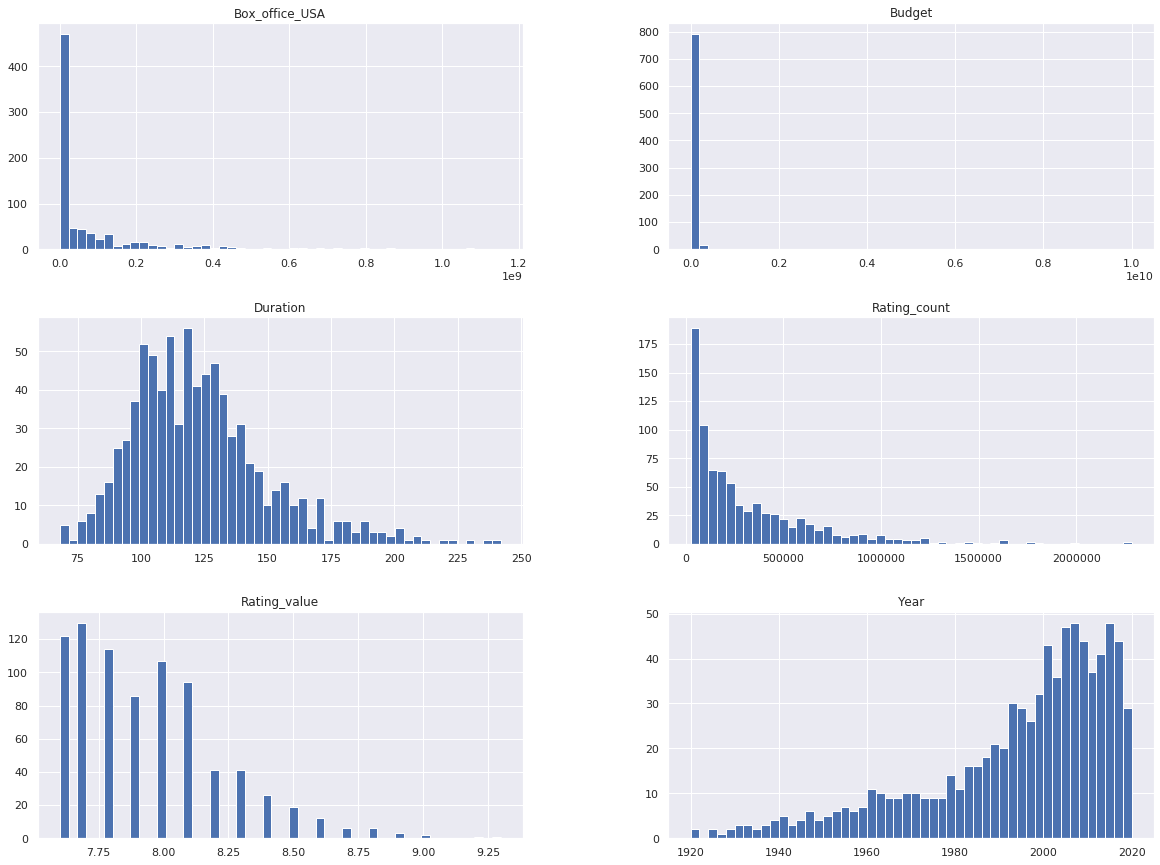

In [822]:
df.hist(column=['Budget', 'Box_office_USA', 'Rating_count', 'Year', 'Duration', 'Rating_value'], figsize=(20, 15), bins=50)
plt.show()


In [823]:
df.corr()['Box_office_world'].sort_values(ascending=False)

Box_office_world   1.00
Box_office_USA     0.85
Rating_count       0.54
Year               0.26
Duration           0.18
Rating_value       0.12
Budget             0.08
Name: Box_office_world, dtype: float64

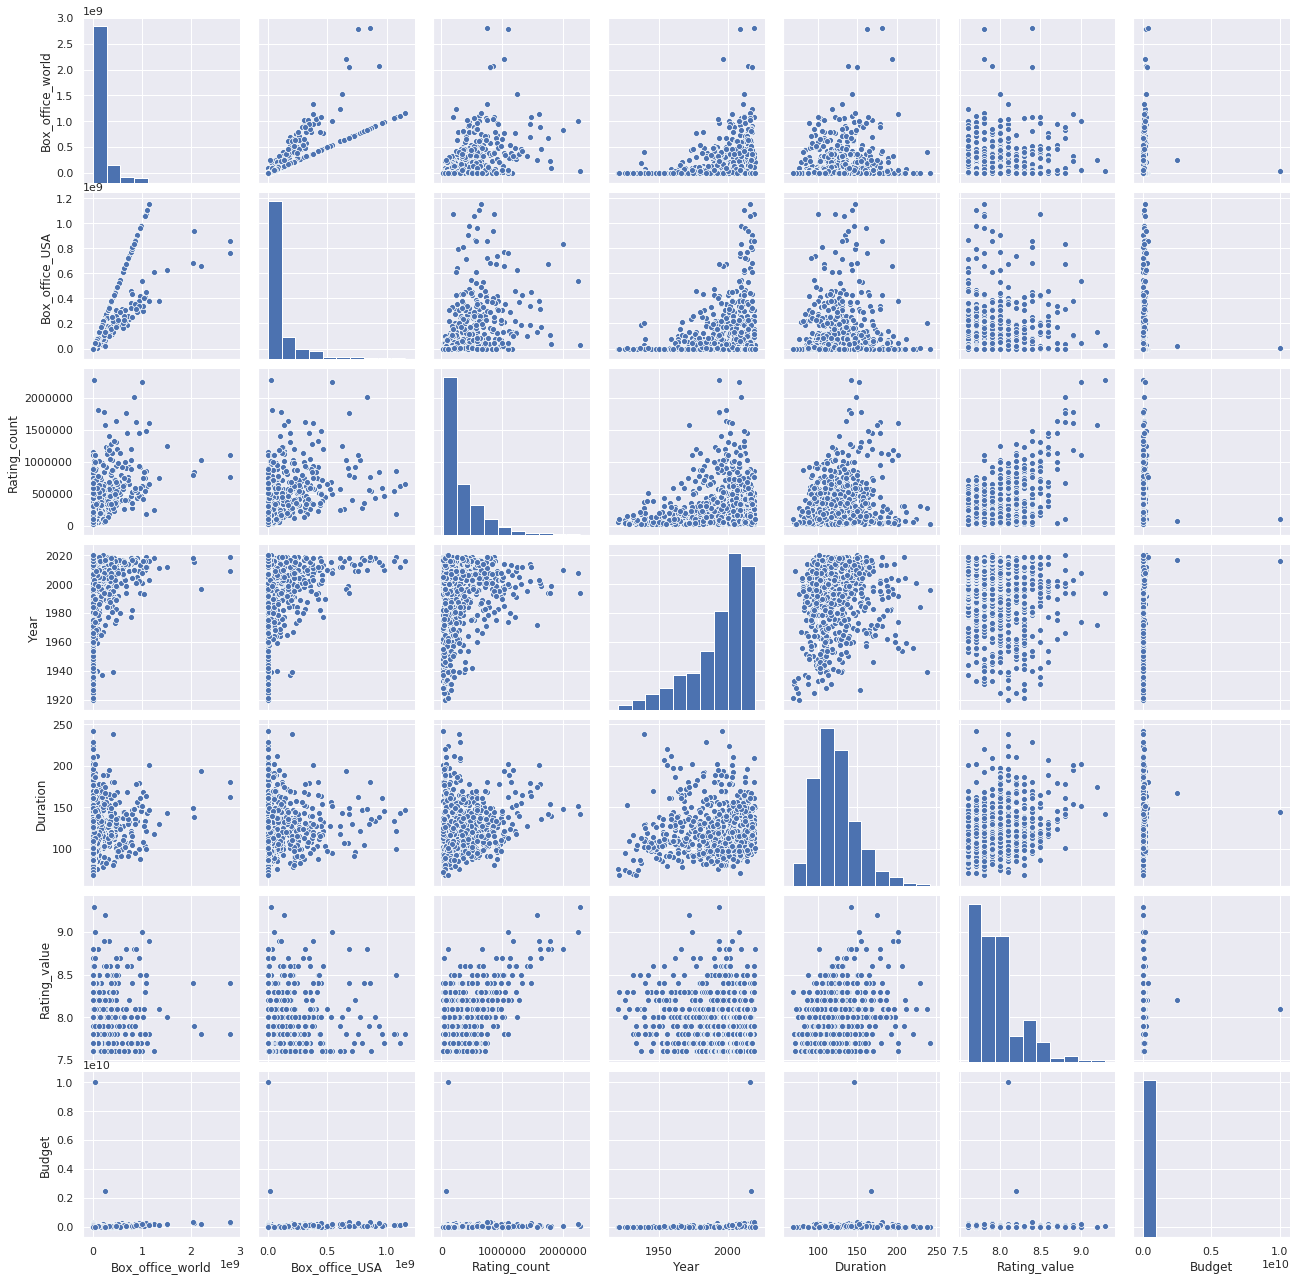

In [824]:
sns.pairplot(df[['Box_office_world', 'Box_office_USA', 'Rating_count', 'Year', 'Duration', 'Rating_value', 'Budget']])

# Train test split

In [825]:
# df.drop(index=movies[(movies['Box_office_world'] == 0)].index, inplace=True)
median = df['Box_office_world'].median()

df['Box_office_world'] = df['Box_office_world'].apply(lambda x: median if x == 0 else x)

In [826]:
data = df.drop(columns=['Box_office_world'])
target = df['Box_office_world'].copy()

In [827]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

In [828]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(608, 11)
(203, 11)
(608,)
(203,)


In [829]:
combined = (X_train.copy(), X_test.copy())

# Visualization 

In [830]:
combined[0].Title.value_counts(dropna=False)

The Girl with the Dragon Tattoo     2
Fitzcarraldo                        1
Y Tu Mamá También                   1
Bicycle Thieves                     1
Tangled                             1
                                   ..
Snow White and the Seven Dwarfs     1
Misery                              1
The Secret in Their Eyes            1
O Brother, Where Art Thou?          1
Despicable Me                       1
Name: Title, Length: 607, dtype: int64

We have two movies with the same title

In [831]:
combined[0][combined[0]['Title'].str.contains('The Girl with the Dragon Tattoo')]

,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA
193,The Girl with the Dragon Tattoo,2011,7.80,412449,David Fincher,158,Crime,USA,English,12768604,232617430
598,The Girl with the Dragon Tattoo,2009,7.80,206286,Niels Arden Oplev,152,Crime,Sweden,Swedish,335502,104414200


Fine. We have the same title but two different movies.

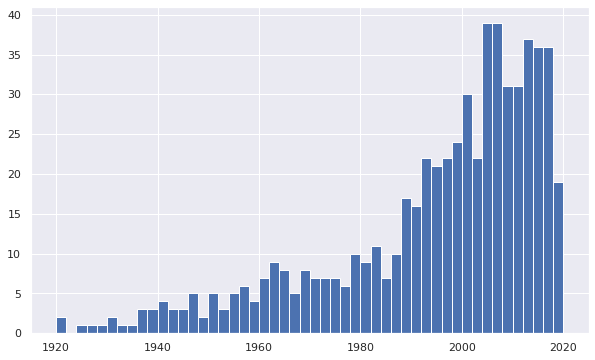

In [832]:
_ = combined[0].Year.hist(bins=50, figsize=(10, 6))

Many movies date from 2000 to 2020. This may be due to the number of films recorded over the past two decades

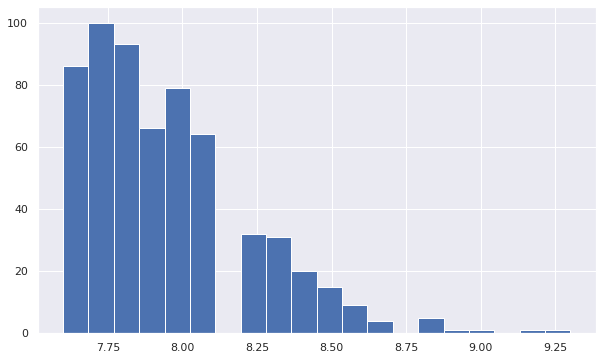

In [833]:
_ = combined[0].Rating_value.hist(bins=20, figsize=(10, 6))

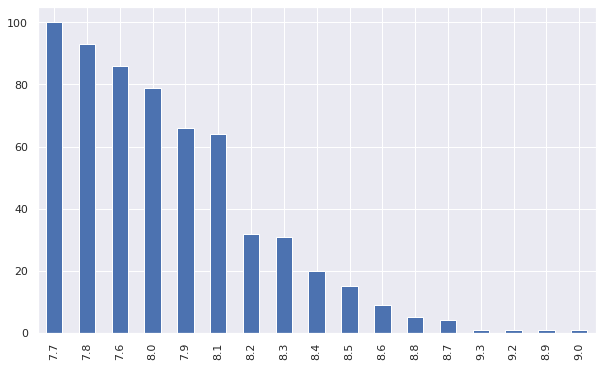

In [834]:
movies_per_rate = combined[0].Rating_value.value_counts(dropna=False)
_ = movies_per_rate.plot(kind='bar', figsize=(10, 6))

The most popular rates are 8.0 and 7.7. Rare rates are 9.0, 9.2, 8.9, 9.3

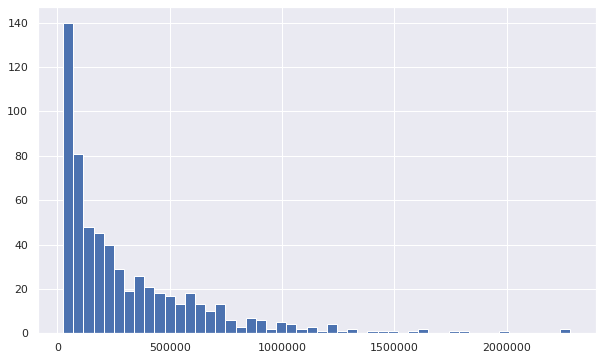

In [835]:
_ = combined[0].Rating_count.hist(bins=50, figsize=(10, 6))

In [836]:
print('Minimum number of votes:', combined[0].Rating_count.max())

Minimum number of votes: 2283372


In [837]:
print('Maximum number of votes:', combined[0].Rating_count.max())

Maximum number of votes: 2283372


In [838]:
most_succesfull_directors = combined[0]['Director'].value_counts(dropna=False)
most_succesfull_directors.head(20)

Steven Spielberg     9
Christopher Nolan    8
Alfred Hitchcock     8
David Fincher        8
Clint Eastwood       7
Hayao Miyazaki       7
Quentin Tarantino    7
Rob Reiner           6
Stanley Kubrick      6
Ridley Scott         6
Wes Anderson         6
Richard Linklater    5
Alfonso Cuarón       5
Charles Chaplin      5
Martin Scorsese      5
Sergio Leone         5
John McTiernan       4
Woody Allen          4
James Cameron        4
Matthew Vaughn       4
Name: Director, dtype: int64

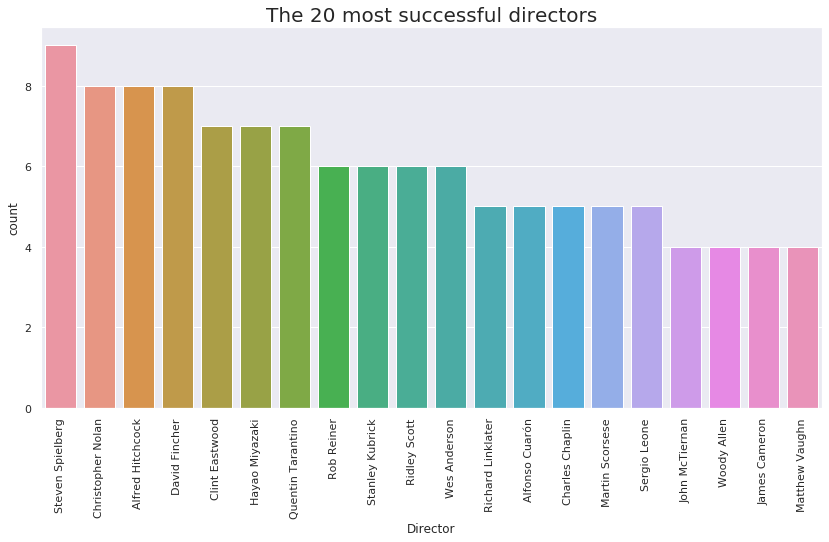

In [839]:
direcotrs_index = most_succesfull_directors.head(20).index

movies_direstors = combined[0][combined[0].Director.isin(direcotrs_index)]
plt.figure(figsize=(14, 7))
sns.countplot(x='Director', data=movies_direstors, order=direcotrs_index)
plt.xticks(rotation=90)
plt.title('The 20 most successful directors', fontsize=20)
plt.show()

In [840]:
directors_mean = combined[0].groupby('Director').mean()
directors_mean = directors_mean.merge(most_succesfull_directors, left_index=True, right_index=True).rename(columns={'Director': 'Num_movies'})
directors_mean.sort_values(by='Budget', ascending=False).head(10)

,Year,Rating_value,Rating_count,Duration,Budget,Box_office_USA,Num_movies
Chan-wook Park,"2,008.00",7.95,"65,480.50",127.50,"5,000,000,000.00","1,003,394.00",2
S.S. Rajamouli,"2,016.00",8.15,"86,593.50",163.00,"1,259,013,074.00","13,462,329.50",2
Nathan Greno,"2,010.00",7.70,"396,795.00",100.00,"260,000,000.00","200,821,936.00",1
Anthony Russo,"2,016.33",7.97,"708,705.00",154.67,"235,046,380.67","757,157,230.67",3
Tate Taylor,"2,011.00",8.00,"420,194.00",146.00,"169,708,112.00",0.00,1
Theodore Melfi,"2,016.00",7.80,"193,822.00",127.00,"169,607,287.00",0.00,1
Don Hall,"2,014.00",7.80,"401,617.00",102.00,"165,000,000.00","222,527,828.00",1
Rich Moore,"2,012.00",7.70,"372,124.00",101.00,"165,000,000.00","189,422,889.00",1
Gabriele Muccino,"2,006.00",8.00,"438,245.00",117.00,"163,566,459.00",0.00,1
Gareth Edwards,"2,016.00",7.80,"539,593.00",133.00,"155,081,681.00","1,056,057,720.00",1


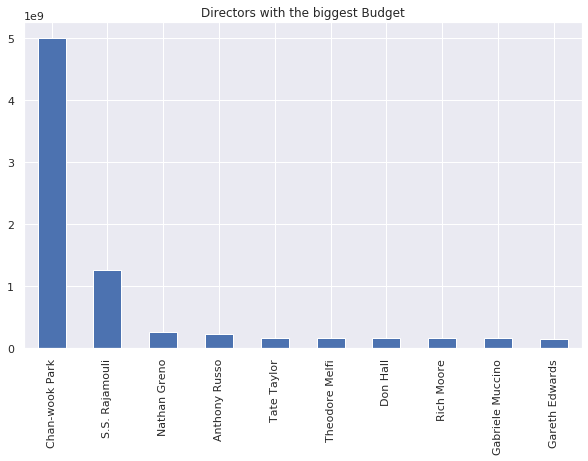

In [841]:
directors_mean['Budget'].sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6))
plt.title("Directors with the biggest Budget")
plt.show()

Anthony Russo and Nathan Greno have the biggest Budget. 

In [842]:
combined[0][combined[0].Director.str.contains(r'(Anthony Russo)|(Nathan Greno)')]

/home/lukas/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA
509,Captain America: The Winter Soldier,2014,7.70,720336,Anthony Russo,136,Action,USA,English,170000000,259766572
488,Tangled,2010,7.70,396795,Nathan Greno,100,Animation,USA,English,260000000,200821936
614,Captain America: Civil War,2016,7.80,645694,Anthony Russo,147,Action,USA,English,179139142,1153332120
980,Avengers: Endgame,2019,8.40,760085,Anthony Russo,181,Action,USA,English,356000000,858373000


In [843]:
directors_mean.sort_values(by='Box_office_USA', ascending=False).head(10)

,Year,Rating_value,Rating_count,Duration,Budget,Box_office_USA,Num_movies
Josh Cooley,"2,019.00",7.80,"190,173.00",100.00,"120,908,065.00","1,073,394,593.00",1
Gareth Edwards,"2,016.00",7.80,"539,593.00",133.00,"155,081,681.00","1,056,057,720.00",1
James Gunn,"2,015.50",7.80,"788,222.00",128.50,"120,415,493.50","818,273,611.50",2
Christopher McQuarrie,"2,018.00",7.70,"281,856.00",147.00,"61,236,534.00","791,120,426.00",1
Anthony Russo,"2,016.33",7.97,"708,705.00",154.67,"235,046,380.67","757,157,230.67",3
Pete Docter,"2,009.00",8.20,"913,196.00",96.00,"68,108,790.00","735,099,102.00",1
Matt Reeves,"2,014.00",7.60,"407,071.00",130.00,"72,611,427.00","710,644,566.00",1
David Yates,"2,010.50",7.90,"604,451.00",138.00,"125,008,686.00","679,181,577.50",2
Todd Phillips,"2,014.00",8.10,"785,112.50",111.00,"65,601,168.50","675,786,907.00",2
Lee Unkrich,"2,013.50",8.35,"547,617.00",104.00,"125,401,302.50","611,044,377.50",2


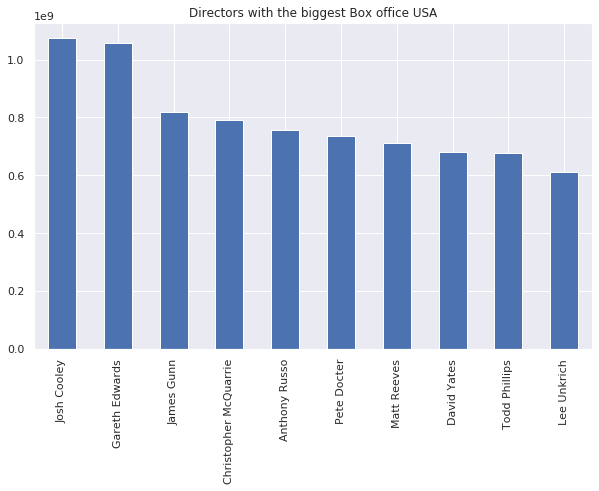

In [844]:
directors_mean['Box_office_USA'].sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6))
plt.title("Directors with the biggest Box office USA")
plt.show()

Gareth Edwards have the biggest Box_office_USA.

In [845]:
combined[0][combined[0].Director.str.contains(r'Gareth Edwards')]

,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA
617,Rogue One: A Star Wars Story,2016,7.80,539593,Gareth Edwards,133,Action,USA,English,155081681,1056057720


In [846]:
directors_mean['Revenue'] = directors_mean.Box_office_USA - directors_mean.Budget

In [847]:
top_direcors_revenue = directors_mean.sort_values(by='Revenue', ascending=False).head(10)
top_direcors_revenue 

,Year,Rating_value,Rating_count,Duration,Budget,Box_office_USA,Num_movies,Revenue
Josh Cooley,"2,019.00",7.80,"190,173.00",100.00,"120,908,065.00","1,073,394,593.00",1,"952,486,528.00"
Gareth Edwards,"2,016.00",7.80,"539,593.00",133.00,"155,081,681.00","1,056,057,720.00",1,"900,976,039.00"
Christopher McQuarrie,"2,018.00",7.70,"281,856.00",147.00,"61,236,534.00","791,120,426.00",1,"729,883,892.00"
James Gunn,"2,015.50",7.80,"788,222.00",128.50,"120,415,493.50","818,273,611.50",2,"697,858,118.00"
Pete Docter,"2,009.00",8.20,"913,196.00",96.00,"68,108,790.00","735,099,102.00",1,"666,990,312.00"
Matt Reeves,"2,014.00",7.60,"407,071.00",130.00,"72,611,427.00","710,644,566.00",1,"638,033,139.00"
Todd Phillips,"2,014.00",8.10,"785,112.50",111.00,"65,601,168.50","675,786,907.00",2,"610,185,738.50"
David Yates,"2,010.50",7.90,"604,451.00",138.00,"125,008,686.00","679,181,577.50",2,"554,172,891.50"
Anthony Russo,"2,016.33",7.97,"708,705.00",154.67,"235,046,380.67","757,157,230.67",3,"522,110,850.00"
Pierre Coffin,"2,010.00",7.60,"491,939.00",95.00,"56,397,125.00","543,113,985.00",1,"486,716,860.00"


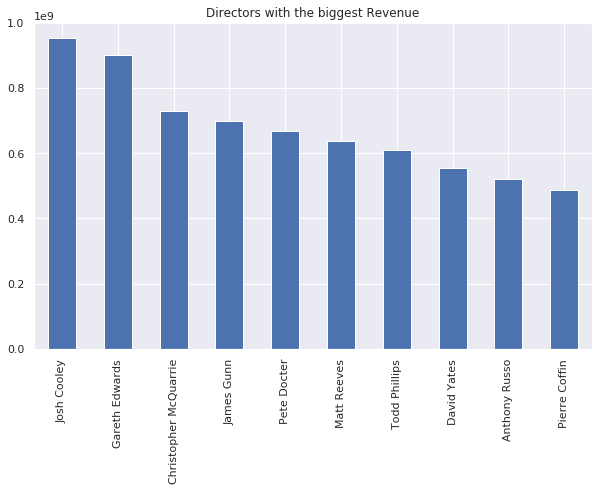

In [848]:
top_direcors_revenue['Revenue'].plot(kind='bar', figsize=(10, 6))
plt.title("Directors with the biggest Revenue")
plt.show()

Gareth Edwards have the biggest Box_office_USA.

Is the country where the films were made significant in terms of revenues?

In [849]:
combined[0][combined[0]['Director'].isin(top_direcors_revenue .index)].Country.value_counts()

USA    13
UK      2
Name: Country, dtype: int64

Answer sounds yes. USA is a  country that increases the chances of making a lot of money from movies.

In [850]:
directors_mean.sort_values(by='Rating_value', ascending=False).head(10)

,Year,Rating_value,Rating_count,Duration,Budget,Box_office_USA,Num_movies,Revenue
Frank Darabont,"1,996.50",8.95,"1,699,302.50",165.50,"42,500,000.00","82,750,675.00",2,"40,250,675.00"
Mukesh Chhabra,"2,020.00",8.80,"102,802.00",101.00,0.00,0.00,1,0.00
Masaki Kobayashi,"1,962.00",8.70,"37,672.00",133.00,0.00,0.00,1,0.00
Lana Wachowski,"1,999.00",8.70,"1,635,540.00",136.00,"63,000,000.00","171,479,930.00",1,"108,479,930.00"
Irvin Kershner,"1,980.00",8.70,"1,134,041.00",124.00,"18,000,000.00","291,286,960.00",1,"273,286,960.00"
George Lucas,"1,977.00",8.60,"1,206,006.00",121.00,"11,000,000.00","460,998,507.00",1,"449,998,507.00"
Frank Capra,"1,946.00",8.60,"388,995.00",130.00,"6,130,720.00",0.00,1,"-6,130,720.00"
Roberto Benigni,"1,997.00",8.60,"607,047.00",116.00,"118,920.00","230,098,753.00",1,"229,979,833.00"
Olivier Nakache,"2,011.00",8.50,"738,187.00",112.00,"103,507.00","426,588,510.00",1,"426,485,003.00"
Michael Curtiz,"1,942.00",8.50,"510,902.00",102.00,"181,494.00","4,374,829.00",1,"4,193,335.00"


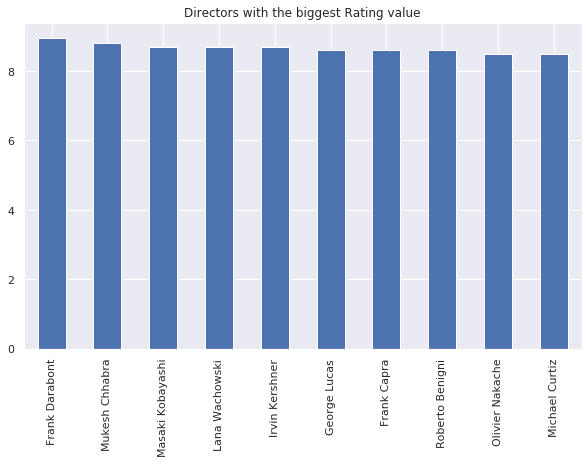

In [851]:
directors_mean['Rating_value'].sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6))
plt.title("Directors with the biggest Rating value")
plt.show()

In [852]:
combined[0][combined[0].Director.str.contains(r'(Frank Darabont)|(Mukesh Chhabra)|(Irvin Kershner)')]

/home/lukas/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA
24,The Green Mile,1999,8.60,1115233,Frank Darabont,189,Crime,USA,English,60000000,136801374
982,Star Wars: Episode V - The Empire Strikes Back,1980,8.70,1134041,Irvin Kershner,124,Action,USA,English,18000000,291286960
0,The Shawshank Redemption,1994,9.30,2283372,Frank Darabont,142,Drama,USA,English,25000000,28699976
992,Dil Bechara,2020,8.80,102802,Mukesh Chhabra,101,Comedy,India,Hindi,0,0


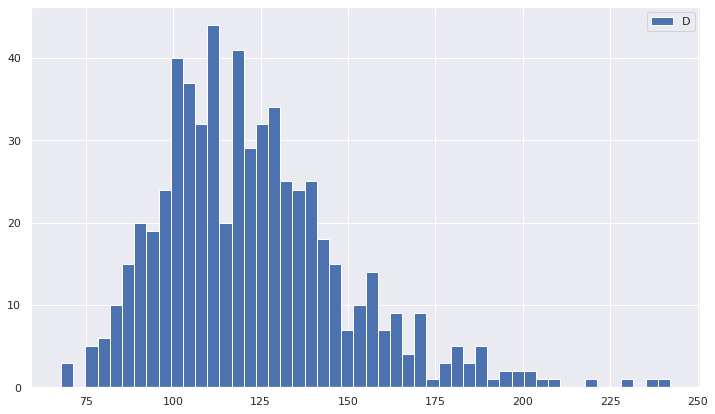

In [853]:
combined[0].Duration.hist(bins=50, figsize=(12, 7))
plt.legend('Duration of movies')
plt.show()

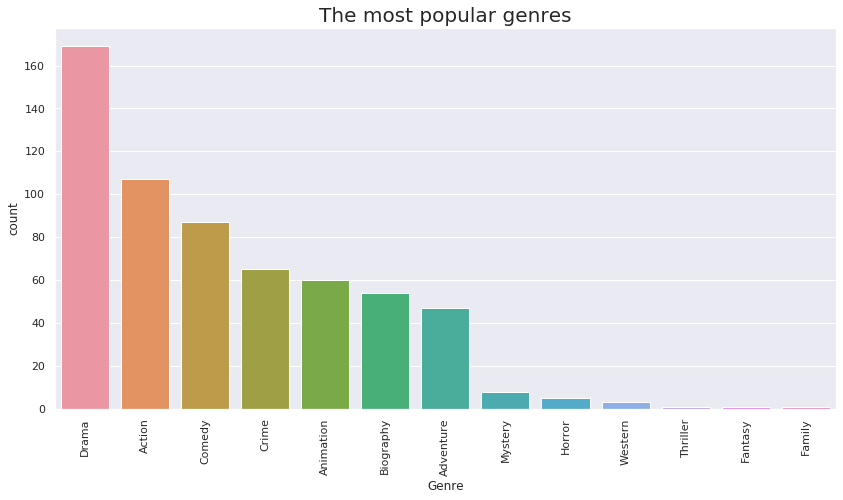

In [854]:
plt.figure(figsize=(14, 7))
sns.countplot(x='Genre', data=combined[0], order=combined[0].Genre.value_counts().index)
plt.xticks(rotation=90)
plt.title('The most popular genres', fontsize=20)
plt.show()

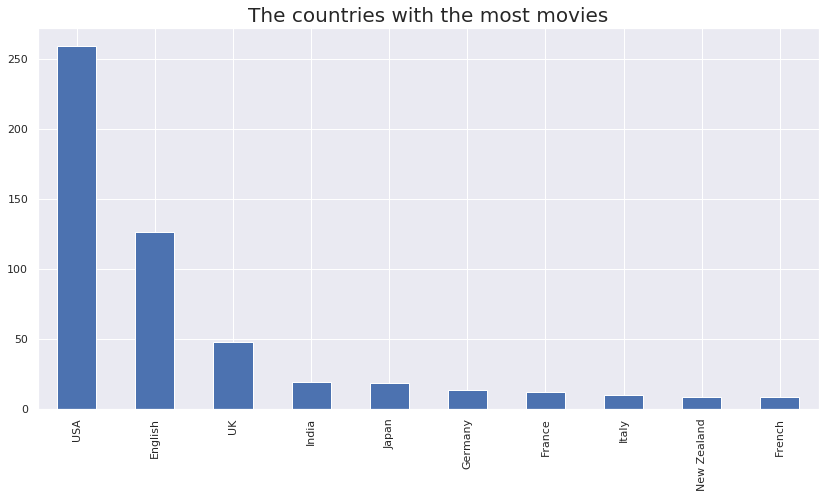

In [855]:
plt.figure(figsize=(14, 7))
combined[0].Country.value_counts(dropna=False).head(10).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('The countries with the most movies', fontsize=20)
plt.show()

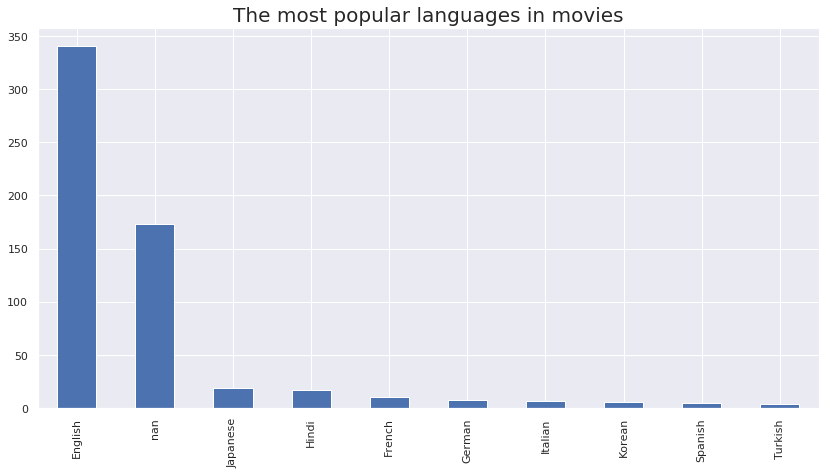

In [856]:
plt.figure(figsize=(14, 7))
combined[0].Language.value_counts(dropna=False).head(10).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('The most popular languages in movies', fontsize=20)
plt.show()

In [857]:
combined[0].Budget.value_counts()

0           49
6000000      9
30000000     6
15000000     6
28000000     5
            ..
265900       1
11340461     1
36785        1
910000       1
6795771      1
Name: Budget, Length: 486, dtype: int64

There are multiple 0 values in the dataframe

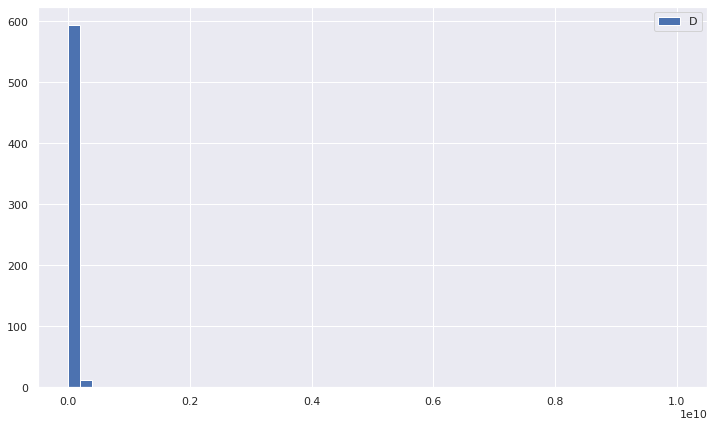

In [858]:
combined[0].Budget.hist(bins=50, figsize=(12, 7))
plt.legend('Duration of movies')
plt.show()

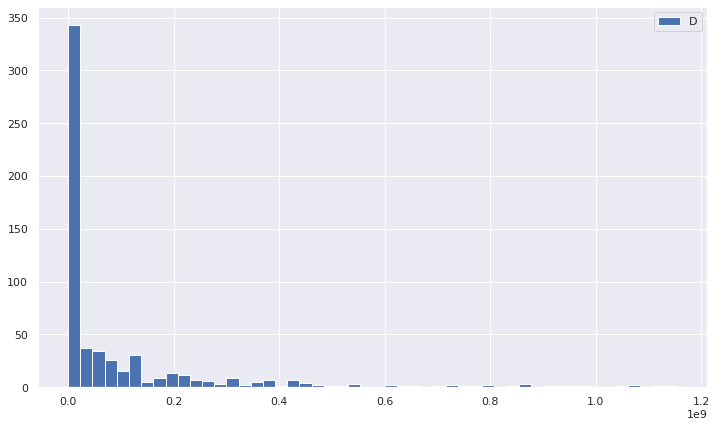

In [859]:
combined[0].Box_office_USA.hist(bins=50, figsize=(12, 7))
plt.legend('Duration of movies')
plt.show()

There are multiple 0 values in the dataframe

# Feature Engineering and Data standardization

In [860]:
combined[0].head()

,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA
501,The Lego Movie,2014,7.70,319713,Christopher Miller,100,Animation,USA,English,60000000,257760692
455,The Muppet Christmas Carol,1992,7.70,46440,Brian Henson,85,Comedy,USA,English,5010109,32319318
486,Black Book,2006,7.70,71643,Paul Verhoeven,145,Drama,Netherlands,Dutch,4398532,0
199,The Wind Rises,2013,7.80,70437,Hayao Miyazaki,126,Animation,Japan,Japanese,136454220,0
82,Amores Perros,2000,8.10,219617,Alejandro G. Iñárritu,154,Drama,Spanish,None,61047,20908467


In [861]:
top_revenue_directors = directors_mean.sort_values('Revenue', ascending=False)['Revenue'].rank().astype(int)
top_revenue_directors

Josh Cooley              385
Gareth Edwards           384
Christopher McQuarrie    383
James Gunn               382
Pete Docter              381
                        ... 
Gabriele Muccino           5
Theodore Melfi             4
Tate Taylor                3
S.S. Rajamouli             2
Chan-wook Park             1
Name: Revenue, Length: 385, dtype: int64

In [862]:
top_box_office_country = combined[0].groupby('Country').sum()['Box_office_USA'].sort_values(ascending=False).rank().astype(int)
top_box_office_country

Country
USA             45
UK              44
New Zealand     43
English         42
France          41
Italy           40
Germany         39
South Africa    38
India           37
Japan           36
Australia       35
China           34
Taiwan          33
Sweden          32
Mexico          31
Canada          30
Poland          29
Ireland         28
Spanish         27
West Germany    26
Indonesia       25
South Korea     24
German          22
Japanese        22
Turkey          21
Turkish         10
Austria         10
Brazil          10
Cantonese       10
Swedish         10
Danish          10
Denmark         10
Spain           10
Korean          10
French          10
Russian         10
Hindi           10
Hong Kong       10
Romanian        10
Iran            10
None            10
Italian         10
Netherlands     10
Maya            10
Argentina       10
Name: Box_office_USA, dtype: int64

In [863]:
# fill na language value
for data in combined:
    data.Language.fillna('Other', inplace=True)

In [864]:
top_box_office_languages = combined[0].groupby('Language').sum()['Box_office_USA'].sort_values(ascending=False).rank().astype(int)
top_box_office_languages

Language
English       21
Other         20
French        19
Mandarin      18
Italian       17
Japanese      16
German        15
Hindi         14
Swedish       13
Spanish       12
Telugu        11
Indonesian    10
Korean         9
Turkish        8
Greek          4
Latin          4
Persian        4
Dutch          4
Danish         4
Chinese        4
Cantonese      4
Name: Box_office_USA, dtype: int64

In [865]:
combined[0].head()

,Title,Year,Rating_value,Rating_count,Director,Duration,Genre,Country,Language,Budget,Box_office_USA
501,The Lego Movie,2014,7.70,319713,Christopher Miller,100,Animation,USA,English,60000000,257760692
455,The Muppet Christmas Carol,1992,7.70,46440,Brian Henson,85,Comedy,USA,English,5010109,32319318
486,Black Book,2006,7.70,71643,Paul Verhoeven,145,Drama,Netherlands,Dutch,4398532,0
199,The Wind Rises,2013,7.80,70437,Hayao Miyazaki,126,Animation,Japan,Japanese,136454220,0
82,Amores Perros,2000,8.10,219617,Alejandro G. Iñárritu,154,Drama,Spanish,Other,61047,20908467


In [866]:
for data in combined:
    data['len_title'] =  data['Title'].apply(len)
    data['Age'] = data['Year'].apply(lambda x: 2020 - x)
    data['Director_rank'] = data['Director'].map(top_revenue_directors)
    data['Director_rank'].fillna(0, inplace=True)
    data['Country_rank'] = data['Country'].map(top_box_office_country)
    data['Language_rank'] = data['Language'].map(top_box_office_languages)
    data.Language.fillna('Other', inplace=True)   

In [867]:
# check correlation with the new variables
pd.concat([combined[0], y_train], axis=1).corr()['Box_office_world'].sort_values(ascending=False)

Box_office_world    1.00
Box_office_USA      0.85
Director_rank       0.55
Rating_count        0.53
Year                0.27
Country_rank        0.25
Language_rank       0.20
Duration            0.18
len_title           0.11
Rating_value        0.10
Budget              0.06
Age                -0.27
Name: Box_office_world, dtype: float64

In [868]:
# delete columns
for data in combined:
    data.drop(columns=['Title', 'Director', 'Country', 'Language', 'Box_office_USA'], inplace=True)
    

I want to drop the Box_office_USA column as this column has a lot of 0 value. This is because many countries don't have salary in USA.

In [869]:
# Write the median instead of 0
budget_median = combined[0].Budget.median()

In [870]:
for data in combined:
    data['Budget'] = data['Budget'].apply(lambda x: budget_median if x == 0 else x)

In [871]:
# chceck budget column
combined[0].Budget.sort_values().head(10)

420    1,861.00
140    5,710.00
789    8,811.00
976    9,102.00
73    10,177.00
731   11,263.00
876   12,562.00
576   15,530.00
1     16,552.00
182   18,177.00
Name: Budget, dtype: float64

In [872]:
# scaler data columns
scaler = StandardScaler()
X_train = scaler.fit_transform(combined[0]._get_numeric_data())
X_test = scaler.transform(combined[1]._get_numeric_data())

In [873]:
# change to dataFrame
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [874]:
combined[1]._get_numeric_data()

,Year,Rating_value,Rating_count,Duration,Budget,len_title,Age,Director_rank,Country_rank,Language_rank
315,1961,7.60,163388,115,"357,750.00",23,59,0.00,45.00,21.00
703,1959,8.00,54895,141,"10,028,113.50",10,61,184.00,42.00,20.00
294,2015,7.60,242131,133,"35,000,000.00",6,5,0.00,45.00,21.00
365,2002,7.60,61205,129,"45,289.00",27,18,1.00,10.00,20.00
657,1993,7.90,86701,94,"1,324,974.00",19,27,0.00,41.00,19.00
...,...,...,...,...,...,...,...,...,...,...
339,1989,7.60,148479,97,"11,750,203.00",38,31,0.00,42.00,20.00
385,2008,7.60,282623,123,"69,951,824.00",13,12,5.00,45.00,21.00
114,2009,8.00,28240,144,"18,613.00",6,11,0.00,10.00,20.00
412,1952,7.70,33901,129,"10,028,113.50",14,68,184.00,42.00,20.00


In [875]:
# add categorical data
X_train['Genre'] = combined[0].select_dtypes('category').values
X_test['Genre'] = combined[1].select_dtypes('category').values

In [876]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,Genre
0,0.94,-0.84,0.01,-0.85,0.02,-0.20,-0.94,1.23,0.57,0.46,Animation
1,-0.10,-0.84,-0.80,-1.41,-0.11,1.21,0.10,0.35,0.57,0.46,Comedy
2,0.56,-0.84,-0.72,0.82,-0.12,-0.67,-0.56,-0.83,-2.99,-4.97,Drama
3,0.89,-0.49,-0.73,0.11,0.20,-0.20,-0.89,-1.31,-0.34,-1.14,Animation
4,0.28,0.55,-0.29,1.15,-0.13,-0.32,-0.28,1.36,-1.26,0.14,Drama


In [877]:
combined[0]

,Year,Rating_value,Rating_count,Duration,Genre,Budget,len_title,Age,Director_rank,Country_rank,Language_rank
501,2014,7.70,319713,100,Animation,"60,000,000.00",15,6,341,45,21
455,1992,7.70,46440,85,Comedy,"5,010,109.00",27,28,241,45,21
486,2006,7.70,71643,145,Drama,"4,398,532.00",11,14,108,10,4
199,2013,7.80,70437,126,Animation,"136,454,220.00",15,7,54,36,16
82,2000,8.10,219617,154,Drama,"61,047.00",14,20,355,27,20
...,...,...,...,...,...,...,...,...,...,...,...
84,2003,8.10,929540,100,Animation,"94,000,000.00",13,17,359,45,21
131,1996,8.00,85789,135,Drama,"1,000,000.00",12,24,239,45,21
344,1991,7.60,25592,118,Animation,"10,028,113.50",15,29,79,36,16
528,1944,7.80,30336,100,Adventure,"10,028,113.50",21,76,184,42,20


In [878]:
# change categorical data
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [883]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   0                608 non-null    float64
 1   1                608 non-null    float64
 2   2                608 non-null    float64
 3   3                608 non-null    float64
 4   4                608 non-null    float64
 5   5                608 non-null    float64
 6   6                608 non-null    float64
 7   7                608 non-null    float64
 8   8                608 non-null    float64
 9   9                608 non-null    float64
 10  Genre_Adventure  608 non-null    uint8  
 11  Genre_Animation  608 non-null    uint8  
 12  Genre_Biography  608 non-null    uint8  
 13  Genre_Comedy     608 non-null    uint8  
 14  Genre_Crime      608 non-null    uint8  
 15  Genre_Drama      608 non-null    uint8  
 16  Genre_Family     608 non-null    uint8  
 17  Genre_Fantasy   

In [885]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   0                203 non-null    float64
 1   1                203 non-null    float64
 2   2                203 non-null    float64
 3   3                203 non-null    float64
 4   4                203 non-null    float64
 5   5                203 non-null    float64
 6   6                203 non-null    float64
 7   7                203 non-null    float64
 8   8                198 non-null    float64
 9   9                198 non-null    float64
 10  Genre_Adventure  203 non-null    uint8  
 11  Genre_Animation  203 non-null    uint8  
 12  Genre_Biography  203 non-null    uint8  
 13  Genre_Comedy     203 non-null    uint8  
 14  Genre_Crime      203 non-null    uint8  
 15  Genre_Drama      203 non-null    uint8  
 16  Genre_Family     203 non-null    uint8  
 17  Genre_Horror    

# Create model

In [653]:
def print_err(x):
    print('Średnia: ', np.mean( x ) / 1000000)
    print('STD:: ', np.std( x ) / 1000000)

In [654]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [655]:
y_pred = linear_reg.predict(X_train)
error = np.sqrt(mean_squared_error(y_train, y_pred))
error / 1000000

221.28916139900534

In [656]:
cross_linear = cross_val_score(linear_reg, cv=10, X=X_train, y=y_train, scoring='neg_mean_squared_error')
print_err(np.sqrt(-cross_linear))

Średnia:  259.0881735924968
STD::  145.23211047767765


In [657]:
svr = SVR()
svr.fit(X_train, y_train)

y_pred = svr.predict(X_train)
error = np.sqrt(mean_squared_error(y_train, y_pred))
error / 1000000

341.0768896525991

In [658]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_train)
error = np.sqrt(mean_squared_error(y_train, y_pred))
error / 1000000

0.0

In [659]:
cross_tree = cross_val_score(tree, cv=10, X=X_train, y=y_train, scoring='neg_mean_squared_error')
print_err(np.sqrt(-cross_tree))

Średnia:  204.13569204587748
STD::  61.06280324296564


In [660]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_train)
error = np.sqrt(mean_squared_error(y_train, y_pred))
error / 1000000

0.7426300415144966

In [661]:
cross_xgb = cross_val_score(xgb_model, cv=10, X=X_train, y=y_train, scoring='neg_mean_squared_error')
print_err(np.sqrt(-cross_xgb))

Średnia:  178.82496921171924
STD::  39.93782803488968


So the best choice for predict Box office XGBoost model. 

# Optimize the best model

First step

In [662]:
param_grid = {
            "n_estimators" : [10, 30, 50] ,
            "max_depth" : [10, 15, 20],
            "learning_rate" : [0.01, 0.02, 0.03],
            "min_child_weight" : [1, 2, 3]
        } 

xgb_grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [663]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
      

In [664]:
xgb_grid.best_params_

{'learning_rate': 0.03,
 'max_depth': 15,
 'min_child_weight': 3,
 'n_estimators': 50}

In [665]:
y_pred = xgb_grid.predict(X_train)

In [666]:
np.sqrt(mean_squared_error(y_train, y_pred)) / 1000000

113.13936433830933

Second step

In [667]:
param_grid = {
            "n_estimators" : [50, 100, 200] ,
            "max_depth" : [6, 8, 10, 12 ],
            "learning_rate" : [0.03, 0.04, 0.05],
            "min_child_weight" : [2, 3, 4, 5]
        } 

xgb_grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

xgb_grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 4,
 'n_estimators': 100}

In [668]:
y_pred = xgb_grid.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred)) / 1000000

30.30023894429603

Third step

In [669]:
param_grid = {
            "n_estimators" : [90, 100, 110, 120 ],
            "max_depth" : [3, 4, 5, 6],
            "learning_rate" : [0.04],
            "min_child_weight" : [5, 10, 15]
        } 

xgb_grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

xgb_grid.best_params_

{'learning_rate': 0.04,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 120}

In [670]:
param_grid = {
            "n_estimators" : [110, 115, 119],
            "max_depth" : [4],
            "learning_rate" : [0.04],
            "min_child_weight" : [5, 6, 7]
        } 

xgb_grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)

xgb_grid.best_params_

{'learning_rate': 0.04,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 119}

In [671]:
y_pred = xgb_grid.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred)) / 1000000

75.4285624413929

## Test the best paramas

In [672]:
# xgb_test = xgb.XGBRegressor(learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=100)
xgb_test = xgb.XGBRegressor(learning_rate=0.04, max_depth=4, min_child_weight=5, n_estimators=119)

xgb_test.fit(X_train, y_train)

y_pred = xgb_test.predict(X_train)
error = np.sqrt(mean_squared_error(y_train, y_pred))
error / 1000000

75.4285624413929

In [673]:
cross_xgb = cross_val_score(xgb_test, cv=10, X=X_train, y=y_train, scoring='neg_mean_squared_error')
print_err(np.sqrt(-cross_xgb))

Średnia:  141.49412438001954
STD::  30.093953006501348


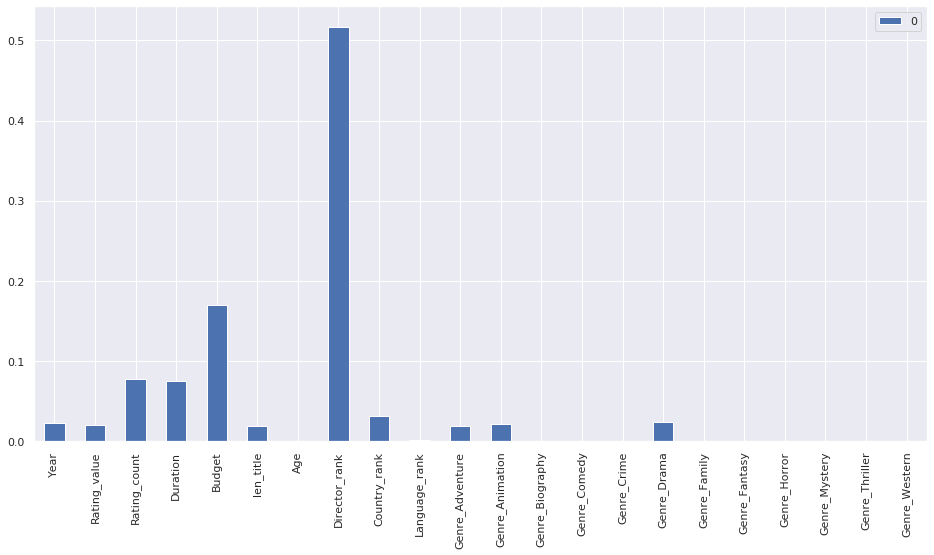

In [674]:
# print most important features
col_names = pd.get_dummies(combined[0], drop_first=True).columns
feat_importance = pd.DataFrame(data=[xgb_test.feature_importances_], columns=col_names)
_ = feat_importance.T.plot(kind='bar', figsize=(16, 8))

In [675]:
combined[0].shape

(608, 11)

In [676]:
feat_importance.loc[1] = np.arange(0, 22)

In [677]:
feat_importance

,Year,Rating_value,Rating_count,Duration,Budget,len_title,Age,Director_rank,Country_rank,Language_rank,...,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Fantasy,Genre_Horror,Genre_Mystery,Genre_Thriller,Genre_Western
0,0.02,0.02,0.08,0.08,0.17,0.02,0.00,0.52,0.03,0.00,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,...,12.00,13.00,14.00,15.00,16.00,17.00,18.00,19.00,20.00,21.00


In [678]:
# value index with a significance greater than 0.02
feat_importance.iloc[1][feat_importance.iloc[0] > 0.02]

Year               0.00
Rating_value       1.00
Rating_count       2.00
Duration           3.00
Budget             4.00
Director_rank      7.00
Country_rank       8.00
Genre_Animation   11.00
Genre_Drama       15.00
Name: 1, dtype: float64

In [679]:
index = feat_importance.iloc[1][feat_importance.iloc[0] > 0.02].values
index

array([ 0.,  1.,  2.,  3.,  4.,  7.,  8., 11., 15.])

In [684]:
xgb_model = xgb.XGBRegressor(learning_rate=0.04, max_depth=4, min_child_weight=5, n_estimators=119)
xgb_model.fit(X_train.iloc[:, index], y_train)

y_pred = xgb_model.predict(X_train.iloc[:, index])
error = np.sqrt(mean_squared_error(y_train, y_pred))
error / 1000000

75.08859279162394

In [685]:
errors = pd.DataFrame({'y_true': y_train})
errors['pred'] = y_pred
errors['diff'] = errors['y_true'] - errors['pred']

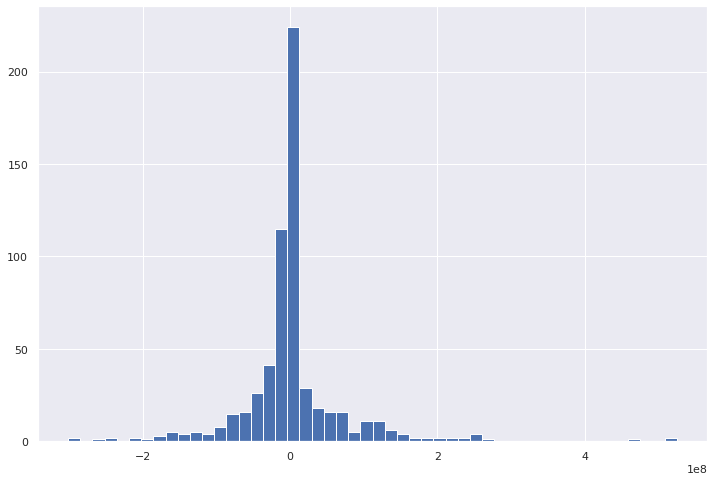

In [686]:
_= errors['diff'].hist(bins=50, figsize=(12, 8))

In [687]:
errors.sort_values(by='diff')

,y_true,pred,diff
766,"1,037,847.00","302,221,696.00","-301,183,849.00"
247,"1,037,847.00","298,623,872.00","-297,586,025.00"
180,"746,045,700.00","1,002,898,752.00","-256,853,052.00"
198,"1,037,847.00","250,652,368.00","-249,614,521.00"
450,"1,037,847.00","238,278,800.00","-237,240,953.00"
...,...,...,...
7,"968,511,805.00","708,913,600.00","259,598,205.00"
244,"1,108,561,013.00","835,560,384.00","273,000,629.00"
399,"1,242,805,359.00","781,349,248.00","461,456,111.00"
590,"2,790,439,092.00","2,276,957,696.00","513,481,396.00"


# Check the model against the test data

In [891]:
y_final_pred = xgb_model.predict(X_test.iloc[:, index])

round(np.sqrt( mean_squared_error(y_test, y_final_pred) ) / 1000000, 2)

200.47

In [902]:
errors = pd.DataFrame({'y_true': y_test})
errors['y_pred'] = y_final_pred
errors['diff'] = errors['y_true'] - errors['y_pred']
errors.sort_values(by='diff').head(20)

,y_true,y_pred,diff
11,"1,037,847.00","636,448,512.00","-635,410,665.00"
965,"521,311,860.00","1,138,160,640.00","-616,848,780.00"
742,"578,981,070.00","1,161,421,952.00","-582,440,882.00"
53,"1,037,847.00","581,510,720.00","-580,472,873.00"
375,"934,409,427.00","1,505,700,608.00","-571,291,181.00"
763,"1,037,847.00","464,419,104.00","-463,381,257.00"
904,"1,037,847.00","455,563,776.00","-454,525,929.00"
945,"131,385,103.00","399,254,112.00","-267,869,009.00"
951,"91,968,688.00","358,077,600.00","-266,108,912.00"
856,"1,037,847.00","261,307,088.00","-260,269,241.00"


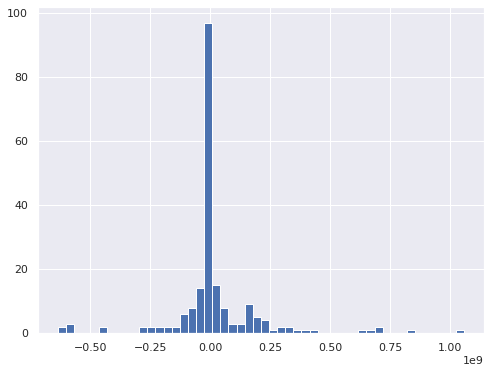

In [909]:
_ = errors['diff'].hist(bins=50, figsize=(8, 6))

# Save best model

In [892]:
import joblib

joblib.dump(xgb_model, 'movies_model.pkl')

['movies_model.pkl']

In [893]:
ls

env/  Model.ipynb  movies.db  movies_model.pkl
